For this lab we will build a model on customer churn binary classification problem. You will be using **Data/DATA_Customer-Churn.csv** file.

**Scenario**

You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

**Instructions**

In this lab, we will first take a look at the degree of imbalance in the data and correct it using the techniques we learned on the class. <br>
Here is the list of steps to be followed (building a simple model without balancing the data):

**Round 1**

- Import the required libraries and modules that you would need. ✅
- Read that data into Python and call the dataframe churnData. ✅
- Check the datatypes of all the columns in the data. You would see that the column TotalCharges is object type. Convert this column into numeric type using pd.to_numeric function. ✅
- Check for null values in the dataframe. Replace the null values. ✅
- Use the following features: tenure, SeniorCitizen, MonthlyCharges and TotalCharges:
    - Scale the features either by using normalizer or a standard scaler. ✅
    - Split the data into a training set and a test set. ✅
    - (optional)Fit a logistic Regression model on the training data.
    - Fit a Knn Classifier(NOT KnnRegressor please!)model on the training data. ✅


# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# Load Original Data

In [2]:
def load_original_data():
    """
    Load original .csv file
    
    OUTPUT
    :dataframe:
    """
    
    df_original = pd.read_csv(r"C:\Users\p.kollhof\Documents\IRONHACK_GitHub\IH_RH_DA_FT_AUG_2022\Class_Materials\Machine_Learning\Supervised_Learning\Lab\Data\DATA_Customer-Churn.csv")
    return df_original

churnData = load_original_data()

# Feature Investigation / EDA

## Check Feature Datatypes

In [3]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

## Describe Numeric Features

In [4]:
churnData.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Turn `TotalCharges` to numeric and replace NaN with median

In [5]:
totalCharges_nanMean = np.nanmedian(pd.to_numeric(churnData["TotalCharges"], errors="coerce"))

churnData["TotalCharges"] = [float(charge.strip()) if len(charge.strip())>0
                            else totalCharges_nanMean
                            for charge in churnData["TotalCharges"]]


In [6]:
churnData.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


## Show Distribution of each Feature

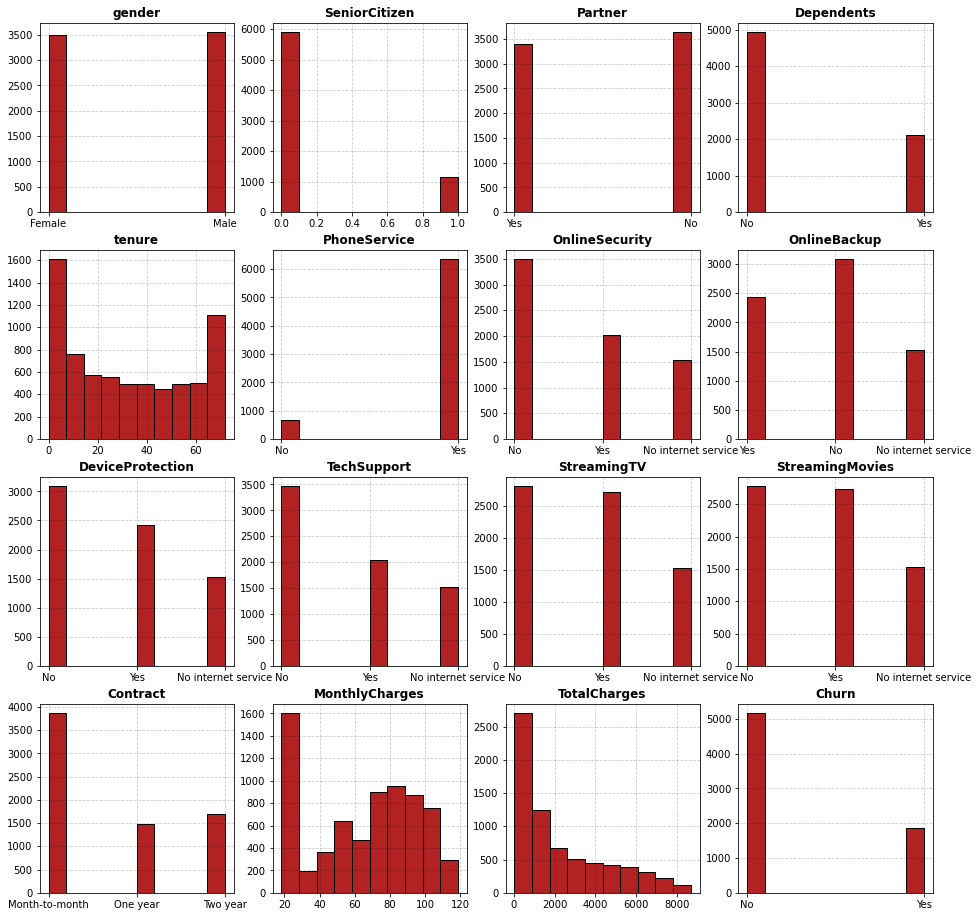

In [7]:
rows = 4
cols = 4
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

fig, ax = plt.subplots(rows, cols,figsize = (16,16))

for p in range(rows*cols):
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--")
    ax[plot_coords[p]].hist(churnData[churnData.columns[p]], edgecolor='k', facecolor="firebrick",
                           )
    ax[plot_coords[p]].set_title(churnData.columns[p], weight="bold")

plt.show()

# Model - KNeighborsClassifier

## X y Split

In [8]:
X = churnData[["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]]
#y = pd.Series([1 if churn == "Yes" else 0 for churn in churnData["Churn"]])
y = churnData["Churn"]

## Call Model, Fit, Transform

In [9]:
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

## Train, Test, Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.20,random_state=42)
X_train.shape, \
X_test.shape, \
y_train.shape, \
y_test.shape

((5634, 4), (1409, 4), (5634,), (1409,))

## Find optimal K (Model Evaluation)

In [11]:
performance_log = pd.DataFrame(columns=["K", 'Accuracy_Train','Precision_Train','Recall_Train',
                                      'Accuracy_Test','Precision_Test','Recall_Test'])

K_list = []
Accuracy_Train = []
Precision_Train = []
Recall_Train = []
Accuracy_Test = []
Precision_Test = []
Recall_Test = []

k_range = range(2, 50)

for k in k_range:
    #if k % 4 == 0:
        #print(f"k = {k}")
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(X_train, y_train)

    y_pred_train = neigh.predict(X_train)
    y_pred_test = neigh.predict(X_test)

    K_list.append(k)
    Accuracy_Train.append(accuracy_score(y_train, y_pred_train))
    Precision_Train.append(precision_score(y_train, y_pred_train, pos_label="Yes"))
    Recall_Train.append(recall_score(y_train, y_pred_train, pos_label="Yes"))
    Accuracy_Test.append(accuracy_score(y_test, y_pred_test))
    Precision_Test.append(precision_score(y_test, y_pred_test, pos_label="Yes"))
    Recall_Test.append(recall_score(y_test, y_pred_test, pos_label="Yes"))
    
performance_log["K"] = K_list
performance_log["Accuracy_Train"] = Accuracy_Train
performance_log["Precision_Train"] = Precision_Train
performance_log["Recall_Train"] = Recall_Train
performance_log["Accuracy_Test"] = Accuracy_Test
performance_log["Precision_Test"] = Precision_Test
performance_log["Recall_Test"] = Recall_Test

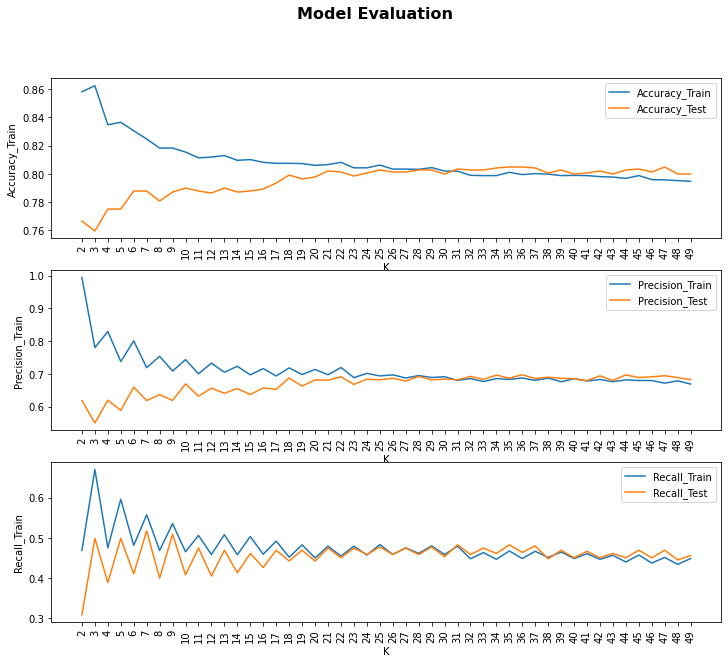

In [12]:
fig, ax = plt.subplots(3,1,figsize=(12,10))
plt.suptitle("Model Evaluation", size=16, weight="bold")
sns.lineplot(x = 'K', y = 'Accuracy_Train', data = performance_log, ax = ax[0], label = "Accuracy_Train")
sns.lineplot(x = 'K', y = 'Accuracy_Test', data = performance_log, ax = ax[0], label = "Accuracy_Test")
sns.lineplot(x = 'K', y = 'Precision_Train', data = performance_log, ax = ax[1], label = "Precision_Train")
sns.lineplot(x = 'K', y = 'Precision_Test', data = performance_log, ax = ax[1], label = "Precision_Test")
sns.lineplot(x = 'K', y = 'Recall_Train', data = performance_log, ax = ax[2], label = "Recall_Train")
sns.lineplot(x = 'K', y = 'Recall_Test', data = performance_log, ax = ax[2], label = "Recall_Test")

k_tick_range = range(2,50,1)
ax[0].set_xticks(k_tick_range)
ax[1].set_xticks(k_tick_range)
ax[2].set_xticks(k_tick_range)
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

plt.show()

## Find Optimal K with GridSearchCV

In [17]:
knn = KNeighborsClassifier()

weight_options = ["uniform"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)

grid = GridSearchCV(knn, param_grid = param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X, y)

K_optimal = grid.best_params_["n_neighbors"]

print(f"Optimal K = {K_optimal} with a score of {round(grid.best_score_,4)}")

#print(grid.best_score_)
#print(grid.best_params_)
#print(grid.best_estimator_)

Optimal K = 23 with a score of 0.7865
0.7864534977433913
{'n_neighbors': 23, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=23)


## KNN Classification with K = 23

In [14]:
performance_log_optimalK = pd.DataFrame(columns=['Accuracy_Train','Precision_Train','Recall_Train',
                                      'Accuracy_Test','Precision_Test','Recall_Test'])

K_list = []
Accuracy_Train = []
Precision_Train = []
Recall_Train = []
Accuracy_Test = []
Precision_Test = []
Recall_Test = []

neigh = KNeighborsClassifier(n_neighbors = K_optimal)
neigh.fit(X_train, y_train)

y_pred_train = neigh.predict(X_train)
y_pred_test = neigh.predict(X_test)

Accuracy_Train.append(accuracy_score(y_train, y_pred_train))
Precision_Train.append(precision_score(y_train, y_pred_train, pos_label="Yes"))
Recall_Train.append(recall_score(y_train, y_pred_train, pos_label="Yes"))
Accuracy_Test.append(accuracy_score(y_test, y_pred_test))
Precision_Test.append(precision_score(y_test, y_pred_test, pos_label="Yes"))
Recall_Test.append(recall_score(y_test, y_pred_test, pos_label="Yes"))

performance_log_optimalK["Accuracy_Train"] = Accuracy_Train
performance_log_optimalK["Precision_Train"] = Precision_Train
performance_log_optimalK["Recall_Train"] = Recall_Train
performance_log_optimalK["Accuracy_Test"] = Accuracy_Test
performance_log_optimalK["Precision_Test"] = Precision_Test
performance_log_optimalK["Recall_Test"] = Recall_Test

performance_log_optimalK

,Accuracy_Train,Precision_Train,Recall_Train,Accuracy_Test,Precision_Test,Recall_Test
0,0.804224,0.688761,0.479278,0.798439,0.667925,0.474531


# Model - LogisticRegression

,Error_metric,Train,Test
0,Accuracy,0.787895,0.806955
1,Precision,0.646829,0.698039
2,Recall,0.443182,0.477212


Confusion matrix for the train set
[[3776  362]
 [ 833  663]]


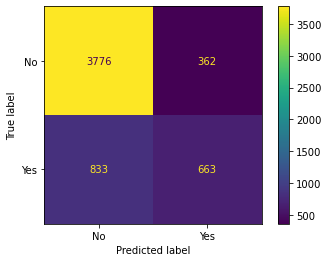


Confusion matrix for the test set
[[959  77]
 [195 178]]


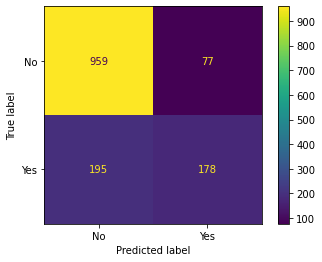

In [15]:
log_model = LogisticRegression() 

## Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

trans = StandardScaler()

trans.fit(X_train)

X_train_mod = trans.transform(X_train)
X_test_mod  = trans.transform(X_test)

log_model.fit(X_train_mod, y_train)

y_pred_train_log = log_model.predict(X_train_mod)
y_pred_test_log = log_model.predict(X_test_mod)

performance_log_LR = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_log),
                                         precision_score(y_train, y_pred_train_log, pos_label="Yes"),
                                         recall_score(y_train, y_pred_train_log, pos_label="Yes")],
                               'Test': [accuracy_score(y_test, y_pred_test_log),
                                        precision_score(y_test, y_pred_test_log, pos_label="Yes"),
                                        recall_score(y_test, y_pred_test_log, pos_label="Yes")]})

display(performance_log_LR)

print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train_log))
plot_confusion_matrix(log_model,X_train_mod,y_train, values_format = 'd')
plt.show()

print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_log))
plot_confusion_matrix(log_model,X_test_mod,y_test, values_format = 'd')
plt.show()